In [1]:
import os
import pandas as pd
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

import missingno as msno

from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV

from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score 

from sklearn.utils.class_weight import compute_sample_weight



import numpy as np
import matplotlib.pyplot as plt
import sage 
import shap

import xgboost as xgb

/home/jlm217/.local/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir('/home/jlm217/rds/rds-mrc-bsu-csoP2nj6Y6Y/mimah/stopah/stopah/data') 

pd.set_option('display.max_columns', None)  

ro.r['load']('STOPAH_ForSolon.RData')

def R_dataset(x):
    with (ro.default_converter + pandas2ri.converter).context():
        stopah = ro.conversion.get_conversion().rpy2py(ro.r[x])
    return stopah

stopah = R_dataset('stopah')

R[write to console]: Warning:
R[write to console]:  namespace ‘pROC’ is not available and has been replaced
by .GlobalEnv when processing object ‘roc.objs’



In [4]:
selected = ['D28_DTH','D90_DTH','Prednisolone']

baseline = ['Gender','Baseline_sepsis','Baseline_GIB',
'Age.at.randomisation..calc.','Weight','Max.grams.of.alcohol.drunk.per.day..calc.','Hepatic.Encephalopathy...Merged',
'Temperature...Merged','Pulse...Merged','Systolic.BP...Merged','Diastolic.BP...Merged','MAP','Hb...Merged','Platelets...Merged',
'WBC...Merged','Neutrophils...Merged','INR...Merged.clinical.and.calc','Bilirubin.Merged','ALT...Merged','ALP...Merged',
'Albumin...Merged','Sodium...Merged','Potassium...Merged','Urea...Merged','Creatinine...Merged','NLR_0','bDNA',
'Ferritin_ngml','Iron_mumoll','Transferrin','TSAT','PNPLA3_Add','PNPLA3_Rec','HPCT_NG'] 

sevenday = ['Hepatic.Encephalopathy...Treatment.Day.7..',
'Day.7.infection',
'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..',
'Temperature..Treatment.Day.7..',
'Pulse..Treatment.Day.7..',
'Systolic.BP..Treatment.Day.7..',
'Diastolic.BP..Treatment.Day.7..',
'MAP..Treatment.Day.7',
'Hb..1.decimal.point..Haematology..Treatment.Day.7..',
'Platelets.day.7',
'WBC.day.7',
'Neutrophils.day.7',
'INR.clinical.and.calc.day.7',
'Bilirubin.day.7',
'ALT.day.7',
'ALP.day.7',
'Albumin.day.7',
'Sodium.day.7',
'Potassium.day.7',
'Urea.day.7',
'Creatinine.day.7']

#reduce data set to target, treatment and therapy

stopah = stopah[baseline+sevenday+['Prednisolone','D28_DTH']]

stopah.reset_index(drop=True, inplace=True)

In [35]:
#complete-case drop very significant 

len(stopah)

1068

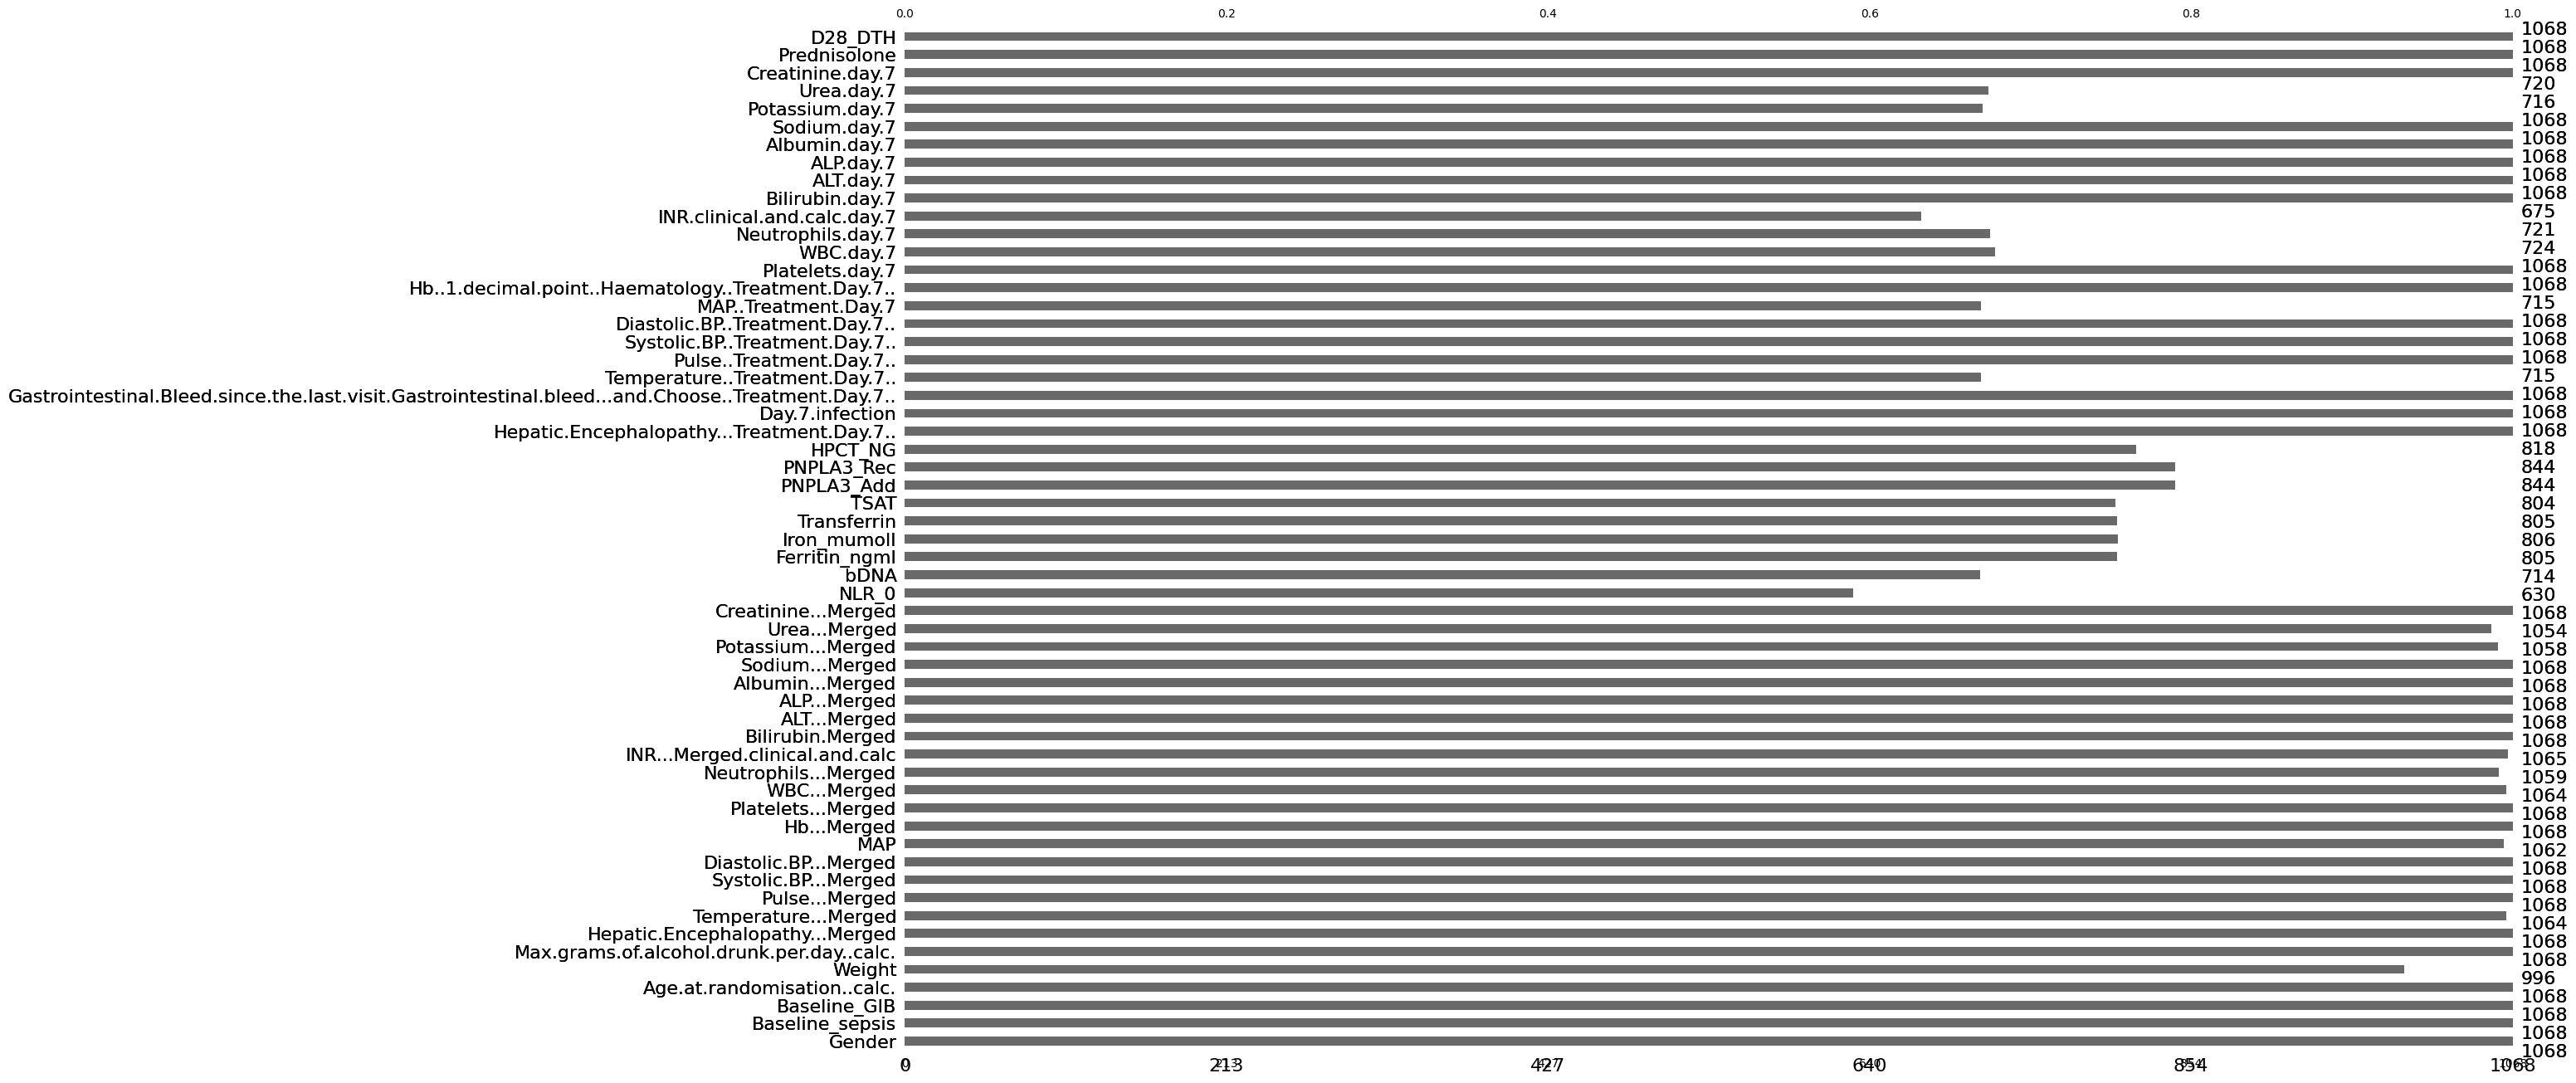

In [49]:
## Missing data situation

%matplotlib inline
msno.bar(stopah)
fig = msno.bar(stopah)
fig_copy = fig.get_figure()

In [36]:
df = stopah.dropna()

In [38]:
len(df)

235

In [39]:
df0 = df[df['Prednisolone']==0].drop(['Prednisolone'],axis=1)

df = df[df['Prednisolone']==1].drop(['Prednisolone'],axis=1)

X, y = df.drop('D28_DTH', axis=1), df[['D28_DTH']]

X0, y0 = df0.drop('D28_DTH', axis=1), df0[['D28_DTH']]

In [40]:
cats = ['Hepatic.Encephalopathy...Treatment.Day.7..', 'Day.7.infection',
              'Gastrointestinal.Bleed.since.the.last.visit.Gastrointestinal.bleed...and.Choose..Treatment.Day.7..']

#for col in cats:
 #   X[col] = X[col].astype('category')

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, random_state=1)

In [27]:
#Train

#Treated

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.5,max_depth=6, random_state=0).fit(X_train, y_train)

#Untreated

clf0= GradientBoostingClassifier(n_estimators=100, learning_rate=0.75,max_depth=6, random_state=0).fit(X0_train, y0_train)


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


### Untreated vs treated training and test performance

In [28]:
print('Untreated')
print()
print('XGB Score:'+str(clf0.score(X0_test, y0_test)))

y0_predict = clf0.predict_proba(X0_test)

auc_score0 = roc_auc_score(y0_test, y0_predict[:,1])
print('AUC Score:',(auc_score0)*100)

print()
print('Treated')
print()

print('XGB Score:'+str(clf.score(X_test, y_test)))

y_predict = clf.predict_proba(X_test)

auc_score = roc_auc_score(y_test, y_predict[:,1])
print('AUC Score:',(auc_score)*100)

Untreated

XGB Score:0.8125
AUC Score: 87.5

Treated

XGB Score:0.7407407407407407
AUC Score: 30.0


In [29]:
### Feature importance treated 

In [1]:
feat_importances = pd.Series(clf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')

NameError: name 'pd' is not defined

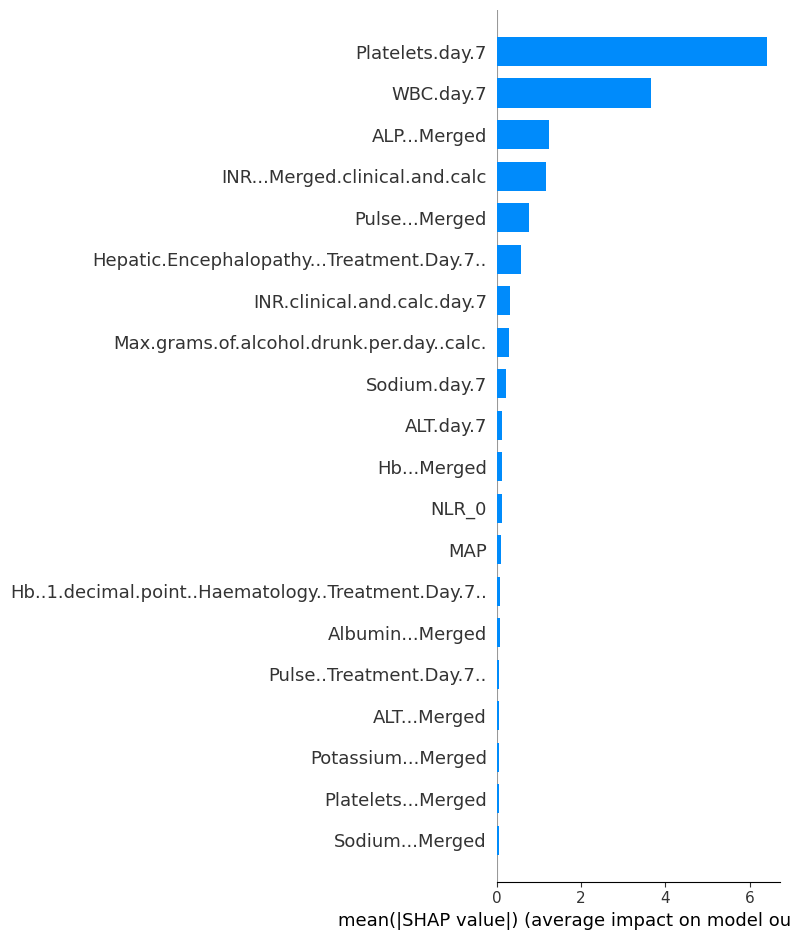

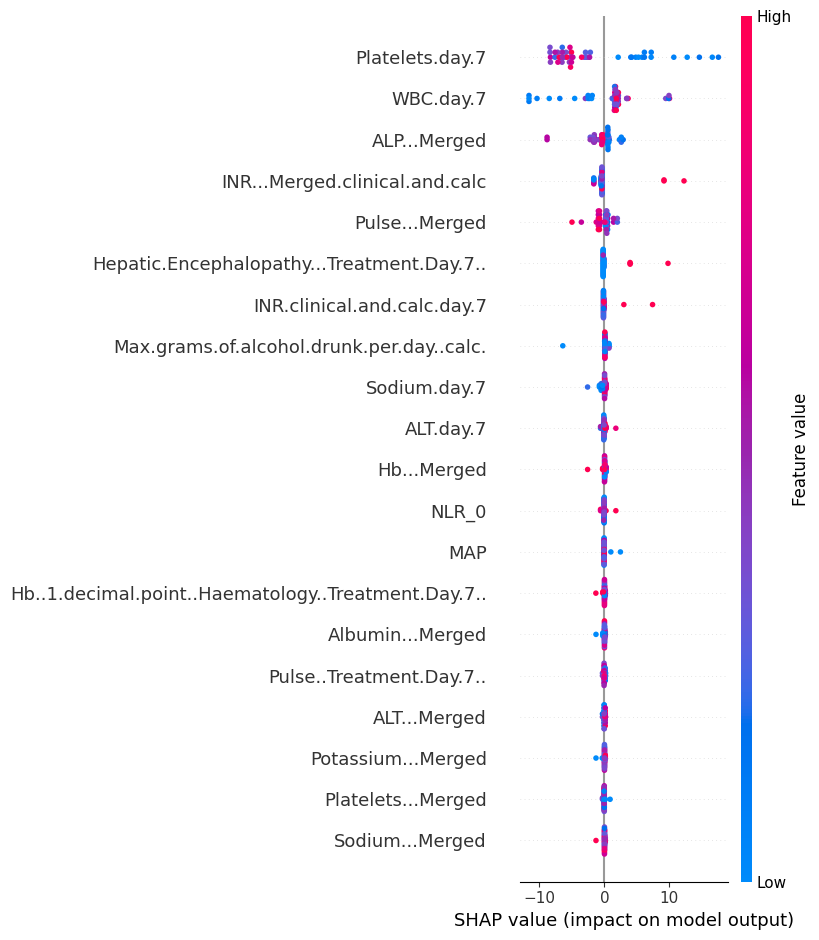

In [45]:
X_sampled = X_train.sample(50, random_state=10)

explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X_sampled)

shap.summary_plot(shap_values, X_sampled, plot_type="bar")

shap.summary_plot(shap_values, X_sampled)

100%|██████████| 1/1 [00:11<00:00, 11.88s/it]     
Plotting 53 features may make figure too crowded, consider using max_features
Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


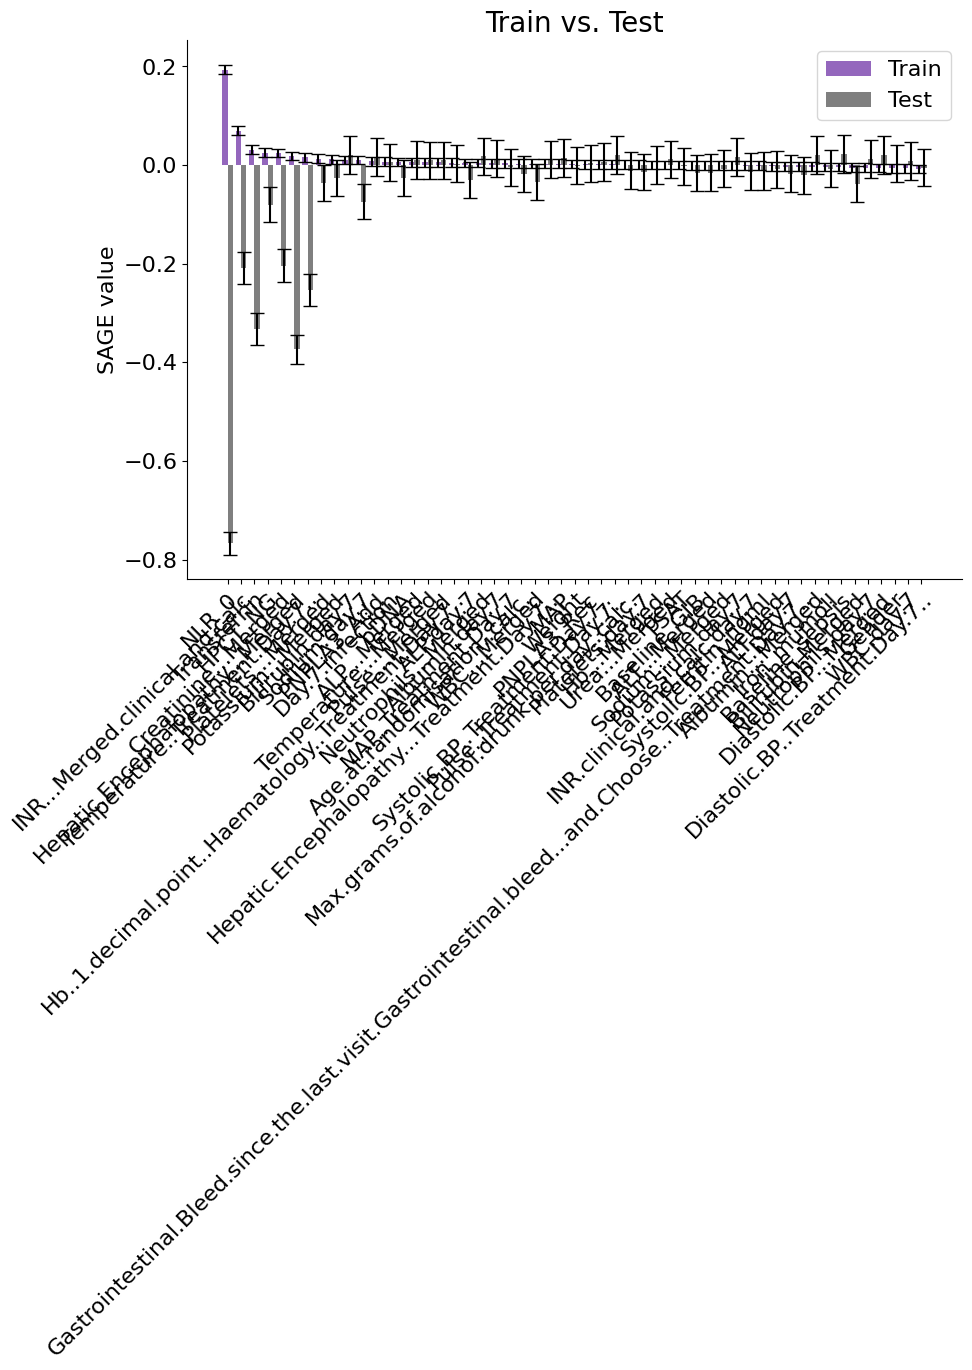

In [46]:
train, test = train_test_split(
    df.values, test_size=int(0.25 * len(df.values)), random_state=123)
y_train = train[:, -1].copy()

y_test = test[:, -1].copy()
X_train = train[:, :-3].copy()

X_test = test[:, :-3].copy()

clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,max_depth=7, random_state=0).fit(X_train, y_train)

imputer = sage.MarginalImputer(clf, X_train[:312])
estimator = sage.KernelEstimator(imputer, 'cross entropy')
sage_train = estimator(X_train, y_train, thresh=0.025)
sage_test = estimator(X_test, y_test, thresh=0.025)

feature_names = df.columns.tolist()[:-2]

sage.comparison_plot((sage_train,sage_test),
                     ('Train',  'Test'),
                     feature_names,
                     colors=('tab:purple', 'tab:grey'),
                     title='Train vs. Test')

### Feature importance Untreated

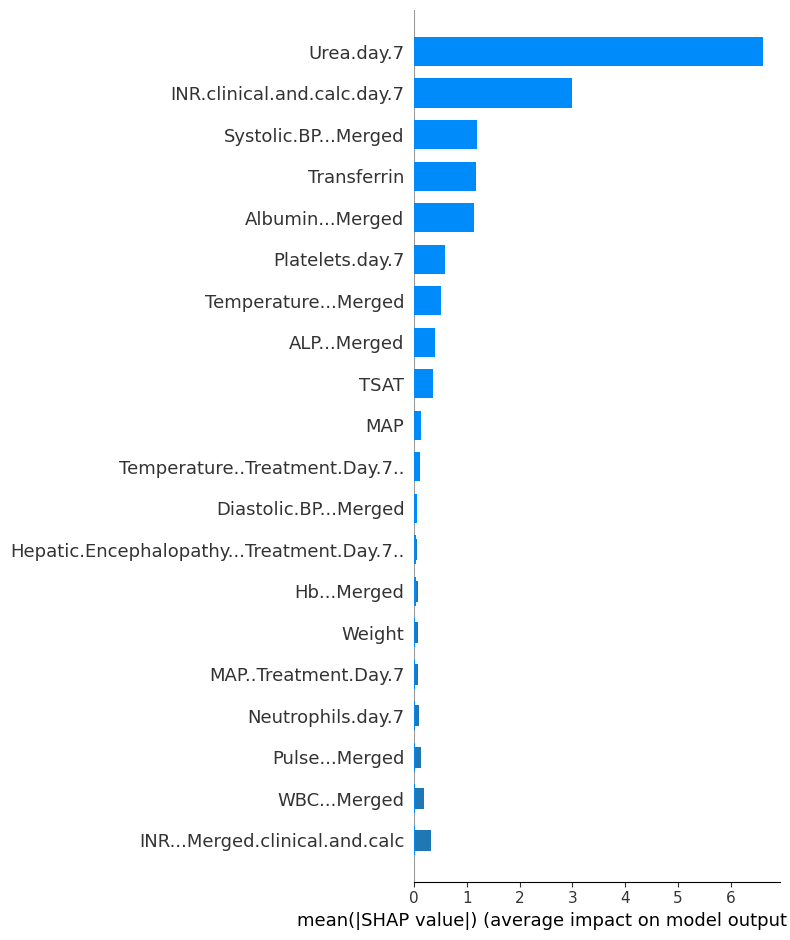

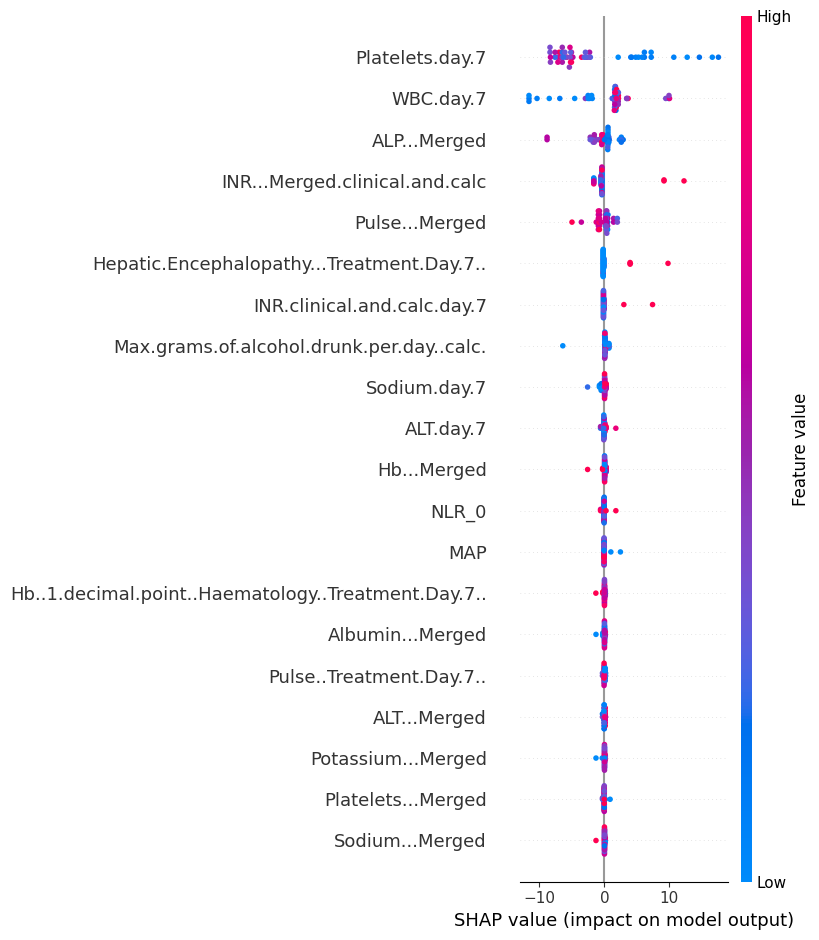

In [47]:
feat_importances = pd.Series(clf0.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')

X0_sampled = X0_train.sample(50, random_state=10)

explainer = shap.TreeExplainer(clf0)
shap0_values = explainer.shap_values(X0_sampled)

shap.summary_plot(shap0_values, X0_sampled, plot_type="bar")

shap.summary_plot(shap_values, X_sampled)

train, test = train_test_split(
    df0.values, test_size=int(0.25 * len(df0.values)), random_state=123)
y0_train = train[:, -1].copy()

y0_test = test[:, -1].copy()
X0_train = train[:, :-3].copy()

X0_test = test[:, :-3].copy()



100%|██████████| 1/1 [00:05<00:00,  5.42s/it]     
Plotting 53 features may make figure too crowded, consider using max_features
Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.


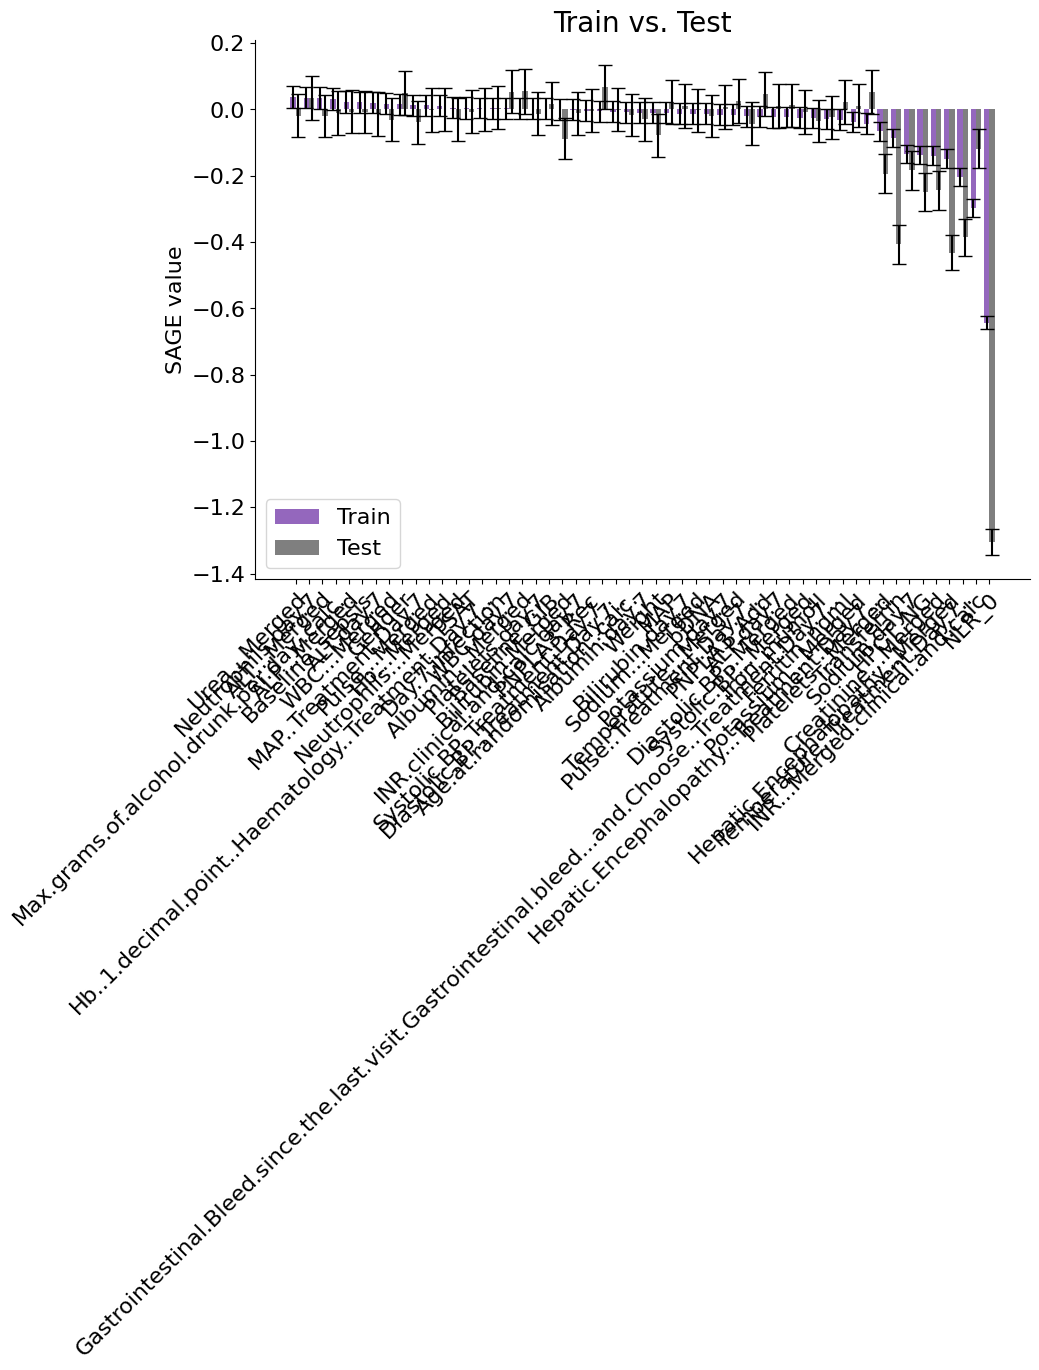

In [48]:
clf0 = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,max_depth=7, random_state=0).fit(X0_train, y0_train)

imputer0 = sage.MarginalImputer(clf, X_train[:312])
estimator0 = sage.KernelEstimator(imputer0, 'cross entropy')
sage_train0 = estimator(X0_train, y0_train, thresh=0.025)
sage_test0 = estimator(X0_test, y0_test, thresh=0.025)

feature_names = df.columns.tolist()[:-2]

sage.comparison_plot((sage_train0,sage_test0),
                     ('Train',  'Test'),
                     feature_names,
                     colors=('tab:purple', 'tab:grey'),
                     title='Train vs. Test')